In [ ]:
import numpy as np
import pandas as pd
import scipy as sc

import dvwtools.read as dv
import dvwtools.stats as dvstats
from IPython.core.display import display

import importlib
import plotly.graph_objects as go
import plotly.express as px

importlib.reload(dvstats)
importlib.reload(dv)

pd.set_option("max_columns", None)
pd.set_option("mode.chained_assignment", "raise")

<h1>Clustering of volleyball players based on performance<span class="tocSkip"></span></h1>

Andrea Biasioli

December 2021

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Main-objective" data-toc-modified-id="Main-objective-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Main objective</a></span></li><li><span><a href="#Intro-to-the-dataset" data-toc-modified-id="Intro-to-the-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Intro to the dataset</a></span></li><li><span><a href="#The-issue-of-different-cardinalities" data-toc-modified-id="The-issue-of-different-cardinalities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The issue of different cardinalities</a></span><ul class="toc-item"><li><span><a href="#Attack" data-toc-modified-id="Attack-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Attack</a></span></li><li><span><a href="#Reception" data-toc-modified-id="Reception-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Reception</a></span></li><li><span><a href="#Serve" data-toc-modified-id="Serve-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Serve</a></span></li></ul></li><li><span><a href="#Tackling-the-issue-of-cardinality-with-standardization" data-toc-modified-id="Tackling-the-issue-of-cardinality-with-standardization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tackling the issue of cardinality with standardization</a></span></li><li><span><a href="#Clustering-dataset" data-toc-modified-id="Clustering-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clustering dataset</a></span></li><li><span><a href="#2D-Study:-attack-reception-plot" data-toc-modified-id="2D-Study:-attack-reception-plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>2D Study: attack-reception plot</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#DBSCAN" data-toc-modified-id="DBSCAN-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>DBSCAN</a></span></li><li><span><a href="#K-Means" data-toc-modified-id="K-Means-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>K-Means</a></span></li><li><span><a href="#Agglomerative-clustering" data-toc-modified-id="Agglomerative-clustering-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Agglomerative clustering</a></span></li><li><span><a href="#Mean-Shift" data-toc-modified-id="Mean-Shift-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Mean Shift</a></span></li><li><span><a href="#Spectral-Clustering-with-Radial-Basis-Function-kernel" data-toc-modified-id="Spectral-Clustering-with-Radial-Basis-Function-kernel-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Spectral Clustering with Radial Basis Function kernel</a></span></li></ul></li><li><span><a href="#3D-Clustering" data-toc-modified-id="3D-Clustering-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>3D Clustering</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#K-Means" data-toc-modified-id="K-Means-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>K-Means</a></span></li><li><span><a href="#Spectral-Clustering-with-Radial-Basis-Function-kernel" data-toc-modified-id="Spectral-Clustering-with-Radial-Basis-Function-kernel-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Spectral Clustering with Radial Basis Function kernel</a></span></li></ul></li><li><span><a href="#3D-Results" data-toc-modified-id="3D-Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>3D Results</a></span></li><li><span><a href="#Issues-with-clustering-models" data-toc-modified-id="Issues-with-clustering-models-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Issues with clustering models</a></span></li><li><span><a href="#Suggestions" data-toc-modified-id="Suggestions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Suggestions</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Main objective

The main goal of this work is to **cluster volleyball players characterized by similar performance metrics**, such as attack kill percentage, positive reception, and so on. More specifically, this work targets the position of **outside hitters**.

Outside hitters are required to perform at high level in many fundamentals: while attack and reception are (maybe?) the most important parameters to evaluate an outside hitter performance, also other fundamentals such as serve, block, and defense are very relevant to the position.

How could we pick an outside hitter for our team?

Looking at every single performance metric individually is helpful, but rankings in different fundamentals might lead to very different results. Players with only few attacks (or defenses, receptions, ...) are subject to more variability in their performance, so a simple ratio *positive outcomes*/*all outcomes* (such as attack kill percentage) can be misleading.

In this work, first we will find a way of **evaluating player performance "independently" of their number of occurrences**, then we will apply **clustering algorithms to group players with similar characteristics**. The clustering algorithms used are: **K-Means, MeanShift, SpectralClustering, Ward Hierarchical Clustering, DBSCAN**.

# Intro to the dataset
The data set includes all data from 2021 Volleyball Nations League and 2020 Tokyo Olympics, for a total of 59'492 rows related to outside hitters performance in 7 different fundamentals. Each row identifies a ball touch of an outside hitters.

Features:
- *team_name* (str): Name of the player's team
- *player_code* (str): ID of the player
- *player_name* (str): name of the player
- *fundamental* (cat): fundamental (A for attack, R for reception, S for serve, D for defense, B for block, E for set, F for freeball)
- *type* (cat): identifies subcategories of the fundamental class (for example, high ball attack, quick ball attack, ...)
- *quality* (cat): quality of the touch. From best to worst: ('#', '+', '!', '-', '/', '=')
- *player_position* (cat): as we are looking at outside hitters, this feature has only two classes: OH1 and OH2 (both selected)



In [51]:
keep_cols = [
    "SquadraNome",
    "CodiceGiocatore",
    "GiocatoreName",
    "fundamental",
    "type",
    "valutazione",
    "CurrentPlayerPosition",
]
df_total = pd.read_parquet("datasets/dataParquet/complete_df.parquet.gzip")
df_total = df_total[df_total.CurrentPlayerPosition.isin(["OH1", "OH2"])]

df_total = df_total[keep_cols]

df_total = df_total.rename(
    columns={
        "SquadraNome": "team_name",
        # 'Partita': 'game_name',
        # 'Competizione': 'competition',
        # 'Round': 'round',
        # 'Date': 'date',
        # 'TeamAvvName': 'opponent_team',
        # 'PuntiInt': 'score_home',
        # 'PuntiOsp': 'score_guest',
        # 'currentset': 'current_game',
        "valutazione": "quality",
        "GiocatoreName": "player_name",
        "CodiceGiocatore": "player_code",
        "CurrentPlayerPosition": "player_position",
    }
)

df_total.player_name = df_total.player_name.astype("str")
df_total.player_code = df_total.player_code.astype("str")
df_total.team_name = df_total.team_name.astype("str")


p_list = pd.read_parquet("datasets/dataParquet/players.parquet.gzip")

In [52]:
print(f"Rows: {len(df_total)}")
print(f"\nFundamentals:\n{df_total.fundamental.value_counts()}")
print(f"\nQualities:\n{df_total.quality.value_counts()}")
print(f"\nQualities order (best to worst): {df_total.quality.cat.categories.values}")

Rows: 59492

Fundamentals:
A    19896
R    15829
S     8913
D     8014
B     3889
E     2083
F      868
Name: fundamental, dtype: int64

Qualities:
#    15751
-    15514
+    12162
!     6637
=     6378
/     3050
Name: quality, dtype: int64

Qualities order (best to worst): ['#' '+' '!' '-' '/' '=']


In [53]:
print(df_total.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59492 entries, 1 to 174071
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   team_name        59492 non-null  object  
 1   player_code      59492 non-null  object  
 2   player_name      59492 non-null  object  
 3   fundamental      59492 non-null  category
 4   type             59491 non-null  category
 5   quality          59492 non-null  category
 6   player_position  59492 non-null  category
dtypes: category(4), object(3)
memory usage: 2.0+ MB
None


In [54]:
display(df_total.sample(10))

,team_name,player_code,player_name,fundamental,type,quality,player_position
158977,Japan,KOG-SAR-96,Koga Sarina,B,H,!,OH2
111853,Serbia,LAZ-KAT-99,Lazovic Katarina,B,Q,=,OH2
166263,Serbia,UZE-ALE-04,Uzelac Aleksandra,A,T,-,OH1
109796,Brazil,GUI-GAB-94,Braga Guimaraes Gabriela,S,M,+,OH1
40328,China,LIX-YIN-00,Li Yingying,B,T,#,OH2
146265,Serbia,MIR-JOV-00,Mirosavljevic Jovana,A,H,/,OH2
150297,Dominican Republic,MAR-BRA-96,Martinez Brayelin Elizabeth,A,H,-,OH2
154105,Netherlands,DAA-NIK-98,Daalderop Nika,B,H,=,OH2
7377,Korea,LEE-SOY-94,Lee Soyoung,E,H,/,OH1
6512,Belgium,HER-BRI-99,Herbots Britt,E,H,+,OH1


# The issue of different cardinalities


## Attack

In [55]:
df_atk = df_total[(df_total.fundamental == "A") & (df_total.type != "O")]
print(f"Attack rows: {len(df_atk)}")

Attack rows: 19279


In [56]:
print("Players and no. of attacks:")
print(df_atk.player_name.value_counts())

Players and no. of attacks:
Kim Yeon Koung              687
Koga Sarina                 672
Braga Guimaraes Gabriela    656
Ishikawa Mayu               656
Rodrigues Fernanda          594
                           ... 
Stragier Manon                3
Plak Celeste                  1
Gryka Aleksandra              1
Mingardi Camilla              1
Vanjak Ivana                  1
Name: player_name, Length: 104, dtype: int64



Some players had many more attacks than others, and a player with only one attack only cannot be compared to players with more than 600 attacks (the kill percentage for players with only one attack can only be either 0% or 100%). A first step to help with this problem is to exclude players with less than 20 attacks.

In [57]:
df_atk = df_atk.assign(scored=[True if val == "#" else False for val in df_atk.quality])
counts = df_atk.scored.value_counts(normalize=True)

p_atk = counts[True]
q_atk = counts[False]

mu_atk = p_atk
sigma_atk = np.sqrt(p_atk * (1 - p_atk))

In [58]:
from dvwtools.stats import Fundamental, Granularity

lower_threshold = 20
zlim = 5

atk_stats = dvstats.get_general_stats(
    df_atk.rename(columns={"player_code": "CodiceGiocatore", "quality": "valutazione"}),
    Fundamental.attack,
    Granularity.players,
    p_list,
)[0]
atk_stats = atk_stats[atk_stats.total > lower_threshold]


from scipy.stats import binom

atk_stats["quantile"] = binom.cdf(k=atk_stats.perfect, n=atk_stats.total, p=p_atk)
n = len(atk_stats)


x = np.divide(atk_stats.perfect, atk_stats.total)
sigma_x = np.divide(sigma_atk, np.sqrt(atk_stats.total))
atk_stats["zscore"] = np.divide(x - mu_atk, sigma_x)
atk_stats.zscore = np.clip(atk_stats.zscore, -zlim, zlim)

In [59]:
from math import sqrt


n_max = max(atk_stats.total)


def get_intervals(p: float, cardinality_max: int):
    z_values_95 = sc.stats.norm.interval(0.95)[1]
    z_values_99 = sc.stats.norm.interval(0.99)[1]

    q = 1 - p

    df_intervals = pd.DataFrame(
        data=[
            (
                n_current,
                100 * (p - z_values_95 * sqrt(p * q / n_current)),
                100 * (p + z_values_95 * sqrt(p * q / n_current)),
                100 * (p - z_values_99 * sqrt(p * q / n_current)),
                100 * (p + z_values_99 * sqrt(p * q / n_current)),
                100 * p,
            )
            for n_current in range(lower_threshold, cardinality_max)
        ],
        columns=["n", "lower95", "upper95", "lower99", "upper99", "mean_value"],
    )
    return df_intervals


df_intervals_atk = get_intervals(p_atk, n_max)

In [60]:
def get_intervals_wilson(p_hat: float, cardinality_max: int, start_n: int):
    z_values_95 = sc.stats.norm.interval(0.95)[1]
    z_values_99 = sc.stats.norm.interval(0.99)[1]

    def get_wilson_mean(phat, z_val, n_elements):
        return (phat + z_val ** 2 / (2 * n_elements)) * (
            1 / (1 + z_val ** 2 / n_elements)
        )

    def get_wilson_additive(phat, z_val, n_elements):
        return (z_val / (1 + z_val ** 2 / n_elements)) * sqrt(
            (phat * (1 - phat) / n_elements) + z_val ** 2 / (4 * n_elements ** 2)
        )

    df_intervals = pd.DataFrame(
        data=[
            (
                n_current,
                100
                * (
                    get_wilson_mean(p_hat, z_values_95, n_current)
                    - get_wilson_additive(p_hat, z_values_95, n_current)
                ),
                100
                * (
                    get_wilson_mean(p_hat, z_values_95, n_current)
                    + get_wilson_additive(p_hat, z_values_95, n_current)
                ),
                100
                * (
                    get_wilson_mean(p_hat, z_values_99, n_current)
                    - get_wilson_additive(p_hat, z_values_99, n_current)
                ),
                100
                * (
                    get_wilson_mean(p_hat, z_values_99, n_current)
                    + get_wilson_additive(p_hat, z_values_99, n_current)
                ),
                100 * get_wilson_mean(p_hat, z_values_95, n_current),
                100 * get_wilson_mean(p_hat, z_values_99, n_current),
            )
            for n_current in range(start_n, cardinality_max)
        ],
        columns=[
            "n",
            "lower95",
            "upper95",
            "lower99",
            "upper99",
            "mean_value",
            "mean_value_99",
        ],
    )
    return df_intervals

In [61]:
df_intervals_atk_wilson = get_intervals_wilson(
    p_atk, max(atk_stats.total), lower_threshold
)

In [62]:
def get_funnel_plot(
    df, x_col, x_title, y_col, y_title, intervals_df, title="Funnel plot"
):
    data_plot = [
        go.Scatter(
            x=df[x_col],
            y=df[y_col],
            text=df.GiocatoreName,
            hovertemplate="<b>%{text}</b><br>Performance: %{y:.2f}% on %{x:.0f}",
            mode="markers",
            name="performance",
            marker_size=10,
        ),
        go.Scatter(
            x=intervals_df.n,
            y=intervals_df.lower95,
            mode="lines",
            marker_color="green",
            name="95% CI",
            hoverinfo="skip",
        ),
        go.Scatter(
            x=intervals_df.n,
            y=intervals_df.upper95,
            mode="lines",
            marker_color="green",
            showlegend=False,
            hoverinfo="skip",
        ),
        go.Scatter(
            x=intervals_df.n,
            y=intervals_df.lower99,
            mode="lines",
            marker_color="red",
            name="99% CI",
            hoverinfo="skip",
        ),
        go.Scatter(
            x=intervals_df.n,
            y=intervals_df.upper99,
            mode="lines",
            marker_color="red",
            showlegend=False,
            hoverinfo="skip",
        ),
        go.Scatter(
            x=intervals_df.n,
            y=intervals_df.mean_value,
            mode="lines",
            name="mean",
            marker_color="gray",
            line_dash="dash",
            hoverinfo="skip",
        ),
    ]

    fig_plotly = go.Figure(data=data_plot)
    fig_plotly.update_layout(
        width=800,
        title=title,
        yaxis=dict(
            range=[0, 100],
            title=y_title,
        ),
        xaxis=dict(
            title=x_title,
            rangemode="nonnegative",
        ),
    )
    return fig_plotly


# funnel_atk = get_funnel_plot(atk_stats, 'total', 'Number of attacks', 'kill', 'attack kill percentage (%)', df_intervals_atk, 'Attack')
# funnel_atk.show()

In [63]:
funnel_atk = get_funnel_plot(
    atk_stats,
    "total",
    "Number of attacks",
    "kill",
    "attack kill percentage (%)",
    df_intervals_atk_wilson,
    "Attack",
)
funnel_atk.show()

From the funnel plot, a lower number of attack is associated to large variance in the performance.

## Reception

In [64]:
df_pass = df_total[(df_total.fundamental == "R")]
print(f"Reception rows: {len(df_pass)}")

df_pass = df_pass.assign(
    positive=np.where(df_pass.quality.isin(["#", "+"]), True, False)
)
df_pass = df_pass.assign(error=np.where(df_pass.quality.isin(["/", "+"]), True, False))
df_pass = df_pass.assign(
    negative=np.where(df_pass.quality.isin(["!", "-"]), True, False)
)

counts_pass = df_pass.positive.value_counts(normalize=True)

p_pass = counts_pass[True]
q_pass = counts_pass[False]

mu_pass = p_pass
sigma_pass = np.sqrt(p_pass * (1 - p_pass))

Reception rows: 15829


In [65]:
pass_stats = dvstats.get_general_stats(
    df_pass.rename(
        columns={"player_code": "CodiceGiocatore", "quality": "valutazione"}
    ),
    Fundamental.reception,
    Granularity.players,
    p_list,
)[0]
pass_stats = pass_stats[pass_stats.total > lower_threshold]

x = np.divide((pass_stats.perfect + pass_stats.positive), pass_stats.total)
sigma_x = np.divide(sigma_pass, np.sqrt(pass_stats.total))
pass_stats["zscore"] = np.divide(x - mu_pass, sigma_x)
pass_stats.zscore = np.clip(pass_stats.zscore, -zlim, zlim)
pass_stats["quantile"] = binom.cdf(
    k=(pass_stats.perfect + pass_stats.positive), n=pass_stats.total, p=p_pass
)
df_intervals_pass = get_intervals_wilson(p_pass, max(pass_stats.total), lower_threshold)
funnel_pass = get_funnel_plot(
    pass_stats,
    "total",
    "Number of receptions",
    "good_perc",
    "R# and R+ percentage (%)",
    df_intervals_pass,
    "Reception",
)
funnel_pass.show()

## Serve

In [66]:
df_serve = df_total[df_total.fundamental == "S"]
df_serve = df_serve[df_serve.player_position.isin(["OH1", "OH2"])]
df_serve = df_serve.assign(is_ace=np.where(df_serve.quality == "#", True, False))
df_serve = df_serve.assign(
    is_good_serve=np.where(df_serve.quality.isin(["#", "/", "+"]), True, False)
)

counts_serve = df_serve.is_good_serve.value_counts(normalize=True)

p_serve = counts_serve[True]
q_serve = counts_serve[False]

mu_serve = p_serve
sigma_serve = np.sqrt(p_serve * (1 - p_serve))

print(f"Serve rows: {len(df_serve)}")

Serve rows: 8913


In [67]:
serve_stats = dvstats.get_general_stats(
    df_serve.rename(
        columns={"player_code": "CodiceGiocatore", "quality": "valutazione"}
    ),
    Fundamental.serve,
    Granularity.players,
    p_list,
)[0]
serve_stats = serve_stats[serve_stats.total > lower_threshold]

x = np.divide(
    (serve_stats.perfect + serve_stats.positive + serve_stats.slash), serve_stats.total
)
sigma_x = np.divide(sigma_serve, np.sqrt(serve_stats.total))
serve_stats["zscore"] = np.divide(x - mu_serve, sigma_x)
serve_stats.zscore = np.clip(serve_stats.zscore, -zlim, zlim)
serve_stats["quantile"] = binom.cdf(
    k=(serve_stats.perfect + serve_stats.positive + serve_stats.slash),
    n=serve_stats.total,
    p=p_serve,
)
df_intervals_serve = get_intervals_wilson(
    p_serve, max(serve_stats.total), lower_threshold
)
funnel_serve = get_funnel_plot(
    serve_stats,
    "total",
    "Number of serves",
    "good_perc",
    "S#, S/, S+ percentage (%)",
    df_intervals_serve,
    "Serve",
)
funnel_serve.show()

# Tackling the issue of cardinality with standardization


Let's take the attack performance as a test case for our standardization process.

In [68]:
print(
    f"Attack: overall success mean p = {p_atk:.4f} with sigma = {sigma_atk:.4f} standard deviation"
)

Attack: overall success mean p = 0.3764 with sigma = 0.4845 standard deviation



We can look at all the attacks and their result (score/no score) as a **binomial distribution** (scored attacks are marked with '#' quality).
The probability of success of each attack will be extracted by the population (i.e., looking at all attacks). In this case, $p=0.376$.
The variance is given by $\sigma^2 = p (1-p)$, so the standard deviation is $\sigma = \sqrt{p (1-p)}$.

For high enough number of attacks $n$, we can use a normal approximation to determine the confidence intervals (Wilson score intervals) for the funnel plots above (in this case, $n$ > 25).

To compare the performance between players with different numbers of attacks, the *cumulative distribution function (CDF)* of the binomial distribution with success probability $p$ will be used.

<br>

### Example: Sarina Koga

In [69]:
display(atk_stats[atk_stats.GiocatoreName == "Koga Sarina"])

valutazione,CodiceGiocatore,total,perfect,positive,negative,snap,slash,errors,kill,efficiency,errors_perc,blocked_perc,GiocatoreName,SquadraCodice,SquadraName,quantile,zscore
46,KOG-SAR-96,672,262,48,248,37,45,32,38.988095,27.529762,4.761905,6.696429,Koga Sarina,JPN,Japan,0.776793,0.720245



Koga Sarina has $n=672$ attacks on record, with k=$262$ successes. The population probability of success is $p_0=0.3762$. Using the binomial CDF:


<code>
p(number_successes <= k) = binom.cdf(k = 262, n = 672, p = 0.3762) = 0.7768 = 77.7%
</code>

According to the binomial success probability $p_0=0.3762$, the probability of scoring 262 times or less on 672 attempts is 78%. Hence, the probability of scoring more than 262 times on 672 attempts is only 22% (Koga is a good performer!).

<br><br>


The mean value of the population for the attack kill performance is $\mu_0 = 0.3762$ and the standard deviation is $\sigma=0.4845$.
The standard score $z$ associated to her performance is given by:

$z = \frac{\hat{x} - \mu_0}{\sigma / \sqrt{n}}$
where $\hat{x}$ is the sample mean, in this case her attack kill percentage.

Hence:
$z = \frac{0.3899 - 0.3762}{0.4845 / \sqrt{672}} = 0.72$

<br>

The standard score $z$ expresses how the performance differed from the mean $\mu_0$. A value of $0$ means the performance was perfectly aligned to the average, positive (negative) values mean that the performance was above (below) the average. The standard deviation of the population $\sigma$ is divided by the square root of the number of attacks $n$ to find the standard deviation of the sample ($n$ attacks - the one related to the current player - are "sampled" from the overall attack population).


Note that the standard score $z$ is not linear with respect to the prediction interval (see plot). Most of the performers (68%) are expected to fall into the (-1, 1) $z$ interval, 95% of them into the (-1.96, 1.96) interval.

It is clear how a $z$ score increase from $z=0$ (approx better than 50%) to $z=0.5$ (better than 84%) is very different to the same absolute increase of $\Delta z=+0.5$ when going from $z=2.5$ (better than 99.4%) to $z=3$ (better than 99.8%).

This means that using the $z$ score as normalized distance measure can be very effective in determining outstanding performance (both *good* and *bad*), while it tends to group most of the players into a relatively narrow center band. This could be desired or not: in this case, the effect is welcome to separate more effectively strong performers.

As the clustering techniques relies mostly on distance measurements, I will cap $z$ to 5 to limit extreme outliers.

In [70]:
prob = np.linspace(0, 1, 250)
z_plot = [sc.stats.norm.interval(p)[1] for p in prob]

fig = px.line(y=np.multiply(prob, 100), x=z_plot, width=800)
fig.update_xaxes(title="Standard score (z)")
fig.update_yaxes(title="Prediction interval (%)")
fig.show()

The same process can be carried out for other fundamentals and their performance index. For example:
- *attack* (seen before): $\text{performance index}=\frac{A_{\text{#}}}{\text{no. of A}}$

- *reception*: $\text{performance index} = \frac{R_{\text{#}} \;+\; R_{\text{+}}}{\text{no. of R}}$

- *serve*: $\text{performance index} = \frac{S_{\text{#}} \;+\; S_{\text{/}} \;+\; S_{\text{+}}}{\text{no. of S}}$

In [71]:
print(
    f"Reception: overall success p = {p_pass:.4f} with {sigma_pass:.4f} standard deviation"
)
print(f"Serve: overall success p = {p_serve:.4f} with {sigma_serve:.4f} std")

Reception: overall success p = 0.5252 with 0.4994 standard deviation
Serve: overall success p = 0.2760 with 0.4470 std


# Clustering dataset
Based on the CDF functions defined above, the dataset for the clustering analysis is defined. We have 74 players (outside hitters) with their performance rating in 3 fundamentals (attack, reception, serve)

In [72]:
keep_pass_cols = ["CodiceGiocatore", "good_perc", "quantile", "zscore"]
keep_serve_cols = ["CodiceGiocatore", "good_perc", "quantile", "zscore"]
keep_atk_cols = ["CodiceGiocatore", "kill", "quantile", "zscore"]

stats_cumulated = atk_stats[keep_atk_cols].merge(
    pass_stats[keep_pass_cols],
    how="inner",
    on="CodiceGiocatore",
    suffixes=["_atk", "_pass"],
)
stats_cumulated = stats_cumulated.merge(
    serve_stats[keep_serve_cols],
    how="inner",
    on="CodiceGiocatore",
    suffixes=["_prev", "_serve"],
)
stats_cumulated = stats_cumulated.rename(columns={"good_perc_prev": "good_perc_pass"})
stats_cumulated = stats_cumulated.rename(
    columns={"quantile": "quantile_serve", "zscore": "zscore_serve"}
)

stats_cumulated = stats_cumulated.merge(
    p_list[["GiocatoreName", "SquadraNome"]],
    how="left",
    left_on="CodiceGiocatore",
    right_index=True,
)
stats_cumulated = stats_cumulated.rename(
    columns={
        "CodiceGiocatore": "player_code",
        "GiocatoreName": "player_name",
        "SquadraNome": "team_name",
    }
)
display(stats_cumulated)

,player_code,kill,quantile_atk,zscore_atk,good_perc_pass,quantile_pass,zscore_pass,good_perc_serve,quantile_serve,zscore_serve,player_name,team_name
0,ALS-LIN-00,42.168675,0.959977,1.702419,58.017493,0.982078,2.039802,30.909091,0.850191,0.950842,Alsmeier Lina,Germany
1,BAL-HAN-97,40.000000,0.864764,1.055143,55.630631,0.913405,1.313608,29.629630,0.783376,0.707728,Baladin Hande,Turkey
2,BAR-MIC-90,37.759336,0.541415,0.053174,61.434978,0.999938,3.771283,25.925926,0.307133,-0.583832,Bartsch-Hackley Michelle,United States of America
3,BLA-JEL-88,22.222222,0.069292,-1.653779,50.000000,0.455859,-0.285188,28.000000,0.617534,0.044726,Blagojevic Jelena,Serbia
4,BOS-CAT-94,44.516129,0.966796,1.766451,62.758621,0.994898,2.469513,25.773196,0.392426,-0.402518,Bosetti Caterina,Italy
...,...,...,...,...,...,...,...,...,...,...,...,...
69,VAN-KIE-99,40.000000,0.717770,0.461725,38.888889,0.013905,-2.315795,25.000000,0.491390,-0.284955,Van Ryk Kiera,Canada
70,VOR-IRI-95,38.671875,0.701687,0.480994,56.136364,0.941729,1.520114,25.000000,0.195437,-0.930661,Voronkova Irina,Russia
71,WIL-SAR-95,42.857143,0.837655,0.854387,55.813953,0.720075,0.432871,36.666667,0.902951,1.110906,Wilhite Parson Sarah,United States of America
72,ZHA-CHA-95,45.842217,0.999880,3.665470,63.839286,0.999756,3.393274,36.111111,0.994998,2.554413,Zhang Changning,China


# 2D Study: attack-reception plot
In the 2D plots:
- (top, right): players performing strongly both in pass and attack
- (top, left): players performing strongly in attack, and poorly in reception
- (bottom, right): players performing strongly in reception, and poorly in attack
- (bottom, left): players performing poorly both in pass and attack

In [73]:
custom = [
    stats_cumulated.team_name,
    stats_cumulated.quantile_pass * 100,
    stats_cumulated.quantile_atk * 100,
]
data = [
    go.Scatter(
        x=stats_cumulated.zscore_pass,
        y=stats_cumulated.zscore_atk,
        text=stats_cumulated.player_name,
        customdata=stats_cumulated.team_name,
        hovertemplate="<b>%{text} (%{customdata})</b><br>Reception: %{x:.4f}<br>Attack: %{y:.4f}",
        mode="markers",
        name="players",
        marker_size=10,
    )
]
fig = go.Figure(data=data)
fig.update_yaxes(
    title="Attack z-score (unscaled)",
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(title="Reception z-score (unscaled)")
fig.update_layout(width=800)
fig.show()

## Preprocessing
We will preprocess the z-scores (for pass and attack) with a StandardScaler. As each of the two performance is scaled individually, the two performances will have comparable scales; this means that all features will have the same importance in clustering.

All clustering plots that follow represent the *scaled* z-scores on the axis, unlike the plot above.

## DBSCAN
DBSCAN tends to group all the center points together, while leaving many of the highest and lowest points ungrouped as outliers. The issue gets worse increasing the neighborhood size and/or the number of samples.

In [74]:
from sklearn.preprocessing import StandardScaler

Xnew = StandardScaler().fit_transform(stats_cumulated[["zscore_pass", "zscore_atk"]])
stats_cumulated["zscore_pass_scaled"] = Xnew[:, 0]
stats_cumulated["zscore_atk_scaled"] = Xnew[:, 1]

In [75]:
from sklearn.cluster import DBSCAN

epsilon = 0.35
samples = 2


db = DBSCAN(eps=epsilon, min_samples=samples)
db = db.fit(Xnew)
stats_cumulated["clusters_dbscan"] = db.labels_
# print(stats_cumulated.clusters_dbscan.value_counts())

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(f"Estimated number of clusters: {n_clusters_:.0f}")
print(f"Estimated number of noise points: {n_noise_:.0f}")

data = []
for i, clust in enumerate(stats_cumulated.clusters_dbscan.unique()):
    sel_df = stats_cumulated[stats_cumulated.clusters_dbscan == clust]

    clust_name = clust
    if clust == -1:
        clust_name = "outliers"

    data.append(
        go.Scatter(
            x=sel_df.zscore_pass_scaled,
            y=sel_df.zscore_atk_scaled,
            customdata=sel_df.clusters_dbscan,
            text=sel_df.player_name,
            hovertemplate="<b>%{text}</b><br>Cluster: %{customdata}<br>Reception: %{x:.4f}<br>Attack: %{y:.4f}<extra></extra>",
            mode="markers",
            name=f"Cluster {clust_name}",
            marker_size=10,
            marker_color=px.colors.qualitative.Bold[i],
        )
    )

fig = go.Figure(data=data)
fig.update_yaxes(
    title="Attack z-score",
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(title="Reception z-score")
fig.update_layout(width=800, title="DBSCAN Clustering")
fig.show()

Estimated number of clusters: 10
Estimated number of noise points: 15


We can look at the descriptive statistics for each performance (reception and attack) metric in each cluster.

In [76]:
eval_df = pd.pivot_table(
    stats_cumulated,
    index="clusters_dbscan",
    values=["zscore_pass_scaled", "zscore_atk_scaled"],
    aggfunc=["mean", "std", "min", "max"],
)
display(eval_df)

mean                                  std  \
                zscore_atk_scaled zscore_pass_scaled zscore_atk_scaled   
clusters_dbscan                                                          
-1                       0.220509          -0.144783          1.531382   
 0                       1.190982           0.944056          0.028990   
 1                       0.529808           0.620541          0.225888   
 2                       0.269979           1.516991          0.219866   
 3                      -0.857378          -0.188710          0.554877   
 4                      -0.803190           0.742374          0.103816   
 5                       0.480833          -0.469184          0.359105   
 6                      -0.459644          -1.849079          0.126083   
 7                       0.183740           1.060647          0.032012   
 8                       0.570800           2.040271          0.041267   
 9                       1.613198           1.681450          0.142643   

                                                 min                     \
                zscore_pass_scaled zscore_atk_scaled zscore_pass_scaled   
clusters_dbscan                                                           
-1                        1.365211         -1.770125          -1.952726   
 0                        0.121328          1.170483           0.858265   
 1                        0.065910          0.289508           0.563928   
 2                        0.046179          0.114510           1.484338   
 3                        0.305456         -1.846185          -0.717903   
 4                        0.159614         -0.936912           0.535612   
 5                        0.506195         -0.078017          -1.296673   
 6                        0.179523         -0.540476          -1.952726   
 7                        0.025948          0.161104           1.042298   
 8                        0.000000          0.541620           2.040271   
 9                        0.023918          1.512335           1.664538   

                              max                     
                zscore_atk_scaled zscore_pass_scaled  
clusters_dbscan                                       
-1                       2.557634           2.040271  
 0                       1.211481           1.029848  
 1                       0.756048           0.699186  
 2                       0.425448           1.549645  
 3                      -0.045984           0.322796  
 4                      -0.689580           0.915962  
 5                       1.321569           0.229560  
 6                      -0.314364          -1.641783  
 7                       0.206376           1.078995  
 8                       0.599980           2.040271  
 9                       1.714062           1.698363

## K-Means
We can use *inertia* to find an "optimal" number of clusters using the *Elbow method*. In this case, $n=3$.

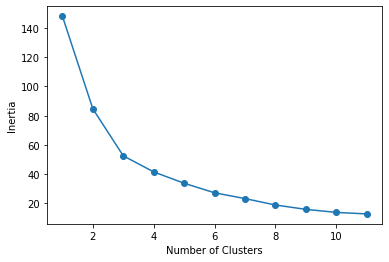

In [77]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

inertia = []
list_num_clusters = list(range(1, 12))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(Xnew)
    inertia.append(km.inertia_)

plt.plot(list_num_clusters, inertia)
plt.scatter(list_num_clusters, inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia");

In [78]:
from sklearn.cluster import KMeans

num_clusters = 3
km = KMeans(n_clusters=num_clusters, random_state=10, n_init=10)
stats_cumulated["clusters_kmeans"] = km.fit(Xnew).labels_
data = []

for i, clust in enumerate(stats_cumulated.clusters_kmeans.unique()):
    sel_df = stats_cumulated[stats_cumulated.clusters_kmeans == clust]
    data.append(
        go.Scatter(
            x=sel_df.zscore_pass_scaled,
            y=sel_df.zscore_atk_scaled,
            customdata=sel_df.clusters_kmeans,
            text=sel_df.player_name,
            hovertemplate="<b>%{text}</b><br>Cluster: %{customdata}<br>Reception: %{x:.4f}<br>Attack: %{y:.4f}<extra></extra>",
            mode="markers",
            name=f"Cluster {clust}",
            marker_size=10,
            marker_color=px.colors.qualitative.Bold[i],
        )
    )

fig = go.Figure(data=data)
fig.update_yaxes(
    title="Attack z-score",
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(title="Reception z-score")
fig.update_layout(width=800)
fig.show()

While these clusters appear reasonable, they group players with very different performance metrics. For example, players with scaled attack z-score of 0 (average) are grouped together with players with scaled attack z-score > 2 (top-tier). In this case, increasing the number of clusters could help to differentiate players classes (in the following case $n=9$).

In [79]:
from sklearn.cluster import KMeans

num_clusters = 9
km = KMeans(n_clusters=num_clusters, random_state=10, n_init=10)
stats_cumulated["clusters_kmeans"] = km.fit(Xnew).labels_
data = []

for i, clust in enumerate(stats_cumulated.clusters_kmeans.unique()):
    sel_df = stats_cumulated[stats_cumulated.clusters_kmeans == clust]
    data.append(
        go.Scatter(
            x=sel_df.zscore_pass_scaled,
            y=sel_df.zscore_atk_scaled,
            customdata=sel_df.clusters_kmeans,
            text=sel_df.player_name,
            hovertemplate="<b>%{text}</b><br>Cluster: %{customdata}<br>Reception: %{x:.4f}<br>Attack: %{y:.4f}<extra></extra>",
            mode="markers",
            name=f"Cluster {clust}",
            marker_size=10,
            marker_color=px.colors.qualitative.Bold[i],
        )
    )
fig = go.Figure(data=data)
fig.update_yaxes(
    title="Attack z-score",
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(title="Reception z-score")
fig.update_layout(width=800)
fig.show()

In [80]:
eval_df = pd.pivot_table(
    stats_cumulated,
    index="clusters_kmeans",
    values=["zscore_pass_scaled", "zscore_atk_scaled"],
    aggfunc=["mean", "median", "std"],
)
display(eval_df)

mean                               median  \
                zscore_atk_scaled zscore_pass_scaled zscore_atk_scaled   
clusters_kmeans                                                          
0                       -1.445098          -0.591792         -1.484022   
1                        0.676237           0.030366          0.611206   
2                        0.569065           1.248964          0.541620   
3                       -0.459644          -1.849079         -0.524093   
4                        2.009948           1.524764          1.838333   
5                        1.058856          -1.761498          0.921557   
6                       -1.126129           0.803439         -0.936912   
7                       -0.471043          -0.028800         -0.441241   
8                        0.160407          -0.932331          0.101314   

                                                 std                     
                zscore_pass_scaled zscore_atk_scaled zscore_pass_scaled  
clusters_kmeans                                                          
0                        -0.581971          0.271905           0.408501  
1                        -0.013526          0.296015           0.323520  
2                         1.078995          0.371758           0.482780  
3                        -1.952726          0.126083           0.179523  
4                         1.664538          0.457938           0.454221  
5                        -1.700028          0.606570           0.169092  
6                         0.720259          0.423548           0.405792  
7                        -0.072708          0.273987           0.232711  
8                        -0.898466          0.390855           0.230768

Let's look at the players in each cluster, sorting the clusters by the mean of zscore_atk_scaled and zscore_pass_scaled (prioritizing the best equilibrium between performance metrics).

In [81]:
cluster_ranking_df = eval_df["mean"]
mean_clusters = cluster_ranking_df[["zscore_atk_scaled", "zscore_pass_scaled"]].mean(
    axis=1
)
cluster_ranking_df = cluster_ranking_df.assign(mean_cluster=mean_clusters)
cluster_ranking_df = cluster_ranking_df.sort_values(by="mean_cluster", ascending=False)
display(cluster_ranking_df)

ranking = pd.Series(cluster_ranking_df.index.values)
for cluster in ranking:
    print(f"Cluster {cluster}")
    display(
        stats_cumulated.loc[
            stats_cumulated.clusters_kmeans == cluster,
            [
                "player_name",
                "kill",
                "zscore_atk_scaled",
                "good_perc_pass",
                "zscore_pass_scaled",
            ],
        ]
    )

,zscore_atk_scaled,zscore_pass_scaled,mean_cluster
clusters_kmeans,,,
4,2.009948,1.524764,1.767356
2,0.569065,1.248964,0.909015
1,0.676237,0.030366,0.353301
6,-1.126129,0.803439,-0.161345
7,-0.471043,-0.028800,-0.249922
5,1.058856,-1.761498,-0.351321
8,0.160407,-0.932331,-0.385962
0,-1.445098,-0.591792,-1.018445
3,-0.459644,-1.849079,-1.154361


Cluster 4


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
21,Braga Guimaraes Gabriela,42.835366,1.838333,68.181818,2.040271
31,Kim Yeon Koung,42.358079,1.714062,62.755102,1.664538
41,Li Yingying,49.070632,2.557634,60.544218,0.821944
60,Rodrigues Fernanda,42.087542,1.512335,61.752988,1.698363
72,Zhang Changning,45.842217,2.427379,63.839286,1.398706


Cluster 2


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
0,Alsmeier Lina,42.168675,1.170483,58.017493,0.858265
2,Bartsch-Hackley Michelle,37.759336,0.114510,61.434978,1.549645
4,Bosetti Caterina,44.516129,1.211481,62.758621,1.029848
8,Busa Bianka,42.857143,0.685244,60.000000,0.699186
18,Geerties Jennifer,38.805970,0.206376,67.567568,1.078995
27,Ishikawa Mayu,39.176829,0.599980,68.583162,2.040271
32,Koga Sarina,38.988095,0.541620,65.517241,2.040271
34,Larson Jordan,40.092166,0.755034,61.333333,1.264736
47,Milenkovic Bojana,38.356164,0.161104,61.748634,1.042298
59,Robinson Kelsey,39.330544,0.425448,68.503937,1.484338


Cluster 1


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
1,Baladin Hande,40.000000,0.756048,55.630631,0.568296
11,Daalderop Nika,39.347409,0.594903,53.689567,0.229560
19,Gorecka Zuzanna,40.186916,0.572466,51.986755,-0.029983
23,Hayashi Kotona,41.379310,0.456612,47.619048,-0.210071
24,Herbots Britt,41.592920,1.321569,53.403141,0.141640
52,Orthmann Hanna,39.043825,0.373971,48.945148,-0.395984
54,Pereira Natalia,40.000000,0.289508,61.538462,0.563928
55,Peña Isabel Yonkaira Paola,41.543027,1.026875,52.229299,0.002932
56,Pietrini Elena,41.549296,0.695792,48.484848,-0.370434
61,Senoglu Tugba,39.631336,0.467744,50.471698,-0.194415


Cluster 6


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
6,Buijs Anne,34.739454,-0.689580,57.412399,0.797663
13,D'Odorico Sofia,29.530201,-1.770125,56.398104,0.494503
15,Ercan Seyma,27.500000,-0.767229,58.762887,0.535612
28,Ishii Yuki,31.292517,-0.936912,61.940299,0.915962
29,Ismailoglu Meliha,30.689655,-1.484178,61.247637,1.649336
30,Jasper Marrit,29.729730,-0.819037,61.290323,0.720259
50,Nizetich Yamila,26.262626,-1.415843,58.035714,0.510738


Cluster 7


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
3,Blagojevic Jelena,22.222222,-0.978411,50.000000,-0.070103
10,Czyrnianska Martyna,32.608696,-0.370681,48.979592,-0.154257
14,Duan Fang,31.132075,-0.805291,48.275862,-0.321525
17,Poll Jana Franziska,35.593220,-0.127508,55.421687,0.255335
22,Guilliams Jodie,33.333333,-0.503010,47.191011,-0.358036
25,Hill Kimberly,34.567901,-0.285168,58.333333,0.322796
35,Lazovic Katarina,35.093168,-0.523976,51.807229,-0.045851
36,Lee Soyoung,35.714286,-0.356353,51.333333,-0.120236
48,Mirosavljevic Jovana,33.333333,-0.773655,53.956835,0.179460
64,Stigrot Lena,36.585366,-0.045984,48.717949,-0.224554


Cluster 5


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
5,Brens Prisilla Rivera,41.379310,0.921557,32.000000,-1.952726
16,Fedorovtseva Arina,42.882562,1.722308,42.118227,-1.631740
45,Melli Giulia,39.768340,0.532704,37.946429,-1.700028


Cluster 8


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
20,Guerra Anastasia,37.500000,0.055010,40.512821,-1.296673
33,Kosheleva Tatyana,37.777778,0.101314,45.512821,-0.655800
37,Leonida Kasaya,36.363636,-0.078017,36.764706,-0.994935
43,Lukasik Martyna,34.909091,-0.518465,44.322344,-1.038958
44,Martinez Brayelin Elizabeth,38.402062,0.278322,36.842105,-1.177919
46,Mercy Moim,34.666667,-0.260062,45.038168,-0.640739
51,Omoruyi Oghosasere Loveth,37.500000,0.059234,42.241379,-0.841220
57,Plummer Kathryn,40.816327,0.374118,41.071429,-0.641135
63,Smirnova Kseniia,41.071429,0.419622,33.823529,-1.188870
65,Stysiak Magdalena,41.447368,0.957302,41.935484,-0.898466


Cluster 0


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
7,Bulaich Daniela,27.722772,-1.236953,35.897436,-1.129938
9,Chuewulim Sutadta,31.417625,-1.248462,50.697674,-0.169599
38,Liu Xiaotong,26.515152,-1.608981,48.076923,-0.399719
39,Liu Yanhan,25.242718,-1.582566,46.551724,-0.319526
40,Livingston Caroline,20.833333,-1.007774,41.176471,-0.603846
42,Lozo Sara,32.440476,-1.179577,47.305389,-0.717903
53,Park Jeongah,31.105991,-1.718996,42.813456,-1.359391
58,Pyo Seungju,24.806202,-1.846185,46.451613,-0.560097
62,Sittirak Onuma,32.661290,-1.385477,45.637584,-0.627747
68,Van Gestel Celine,31.203931,-1.636011,52.073733,-0.030156


Cluster 3


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled
12,De La Cruz De Peña Bethania,35.470085,-0.540476,38.495575,-1.641783
26,Howe Hilary,35.135135,-0.524093,28.846154,-1.952726
49,Mitrovic Andrea,36.056338,-0.314364,34.929577,-1.952726


## Agglomerative clustering
Agglomerative clustering with 'ward' linkage leads to results similar to K-Means for this dataset.

In [82]:
from sklearn.cluster import AgglomerativeClustering

### BEGIN SOLUTION
ag = AgglomerativeClustering(n_clusters=9, linkage="ward", compute_full_tree=True)
ag = ag.fit(Xnew)
stats_cumulated["clusters_aggl"] = ag.fit_predict(Xnew)
data = []
for i, clust in enumerate(stats_cumulated.clusters_aggl.unique()):
    sel_df = stats_cumulated[stats_cumulated.clusters_aggl == clust]
    data.append(
        go.Scatter(
            x=sel_df.zscore_pass_scaled,
            y=sel_df.zscore_atk_scaled,
            customdata=sel_df.clusters_aggl,
            text=sel_df.player_name,
            hovertemplate="<b>%{text}</b><br>Cluster: %{customdata}<br>Reception: %{x:.4f}<br>Attack: %{y:.4f}<extra></extra>",
            mode="markers",
            name=f"Cluster {clust}",
            marker_size=10,
            marker_color=px.colors.qualitative.Bold[i],
        )
    )
fig = go.Figure(data=data)
fig.update_yaxes(
    title="Attack z-score",
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(title="Reception z-score")
fig.update_layout(width=800, title="Agglomerative Clustering (Ward)")
fig.show()

## Mean Shift
Mean shift cluster points based on local density in a predefined window/bandwidth. In this case it offers good performance in separating top and bottom performers. On the other hand, some points that appear very close to each other for average performance are sometimes assigned to different clusters.

In [85]:
from sklearn.cluster import MeanShift

### BEGIN SOLUTION
ms = MeanShift(bandwidth=0.8)
ms = ms.fit(Xnew)
stats_cumulated["clusters_ms"] = ms.fit_predict(Xnew)
data = []
for i, clust in enumerate(stats_cumulated.clusters_ms.unique()):
    sel_df = stats_cumulated[stats_cumulated.clusters_ms == clust]
    data.append(
        go.Scatter(
            x=sel_df.zscore_pass_scaled,
            y=sel_df.zscore_atk_scaled,
            customdata=sel_df.clusters_ms,
            text=sel_df.player_name,
            hovertemplate="<b>%{text}</b><br>Cluster: %{customdata}<br>Reception: %{x:.4f}<br>Attack: %{y:.4f}<extra></extra>",
            mode="markers",
            name=f"Cluster {clust}",
            marker_size=10,
            marker_color=px.colors.qualitative.Bold[i],
        )
    )
fig = go.Figure(data=data)
fig.update_yaxes(
    title="Attack z-score",
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(title="Reception z-score")
fig.update_layout(width=800, title="Mean Shift")
fig.show()

## Spectral Clustering with Radial Basis Function kernel

In [86]:
from sklearn.cluster import SpectralClustering

### BEGIN SOLUTION
spc = SpectralClustering(n_clusters=8, random_state=42, affinity="rbf", gamma=0.4)
spc = spc.fit(Xnew)
stats_cumulated["clusters_spc"] = spc.fit_predict(Xnew)
data = []
for i, clust in enumerate(stats_cumulated.clusters_spc.unique()):
    sel_df = stats_cumulated[stats_cumulated.clusters_spc == clust]
    data.append(
        go.Scatter(
            x=sel_df.zscore_pass_scaled,
            y=sel_df.zscore_atk_scaled,
            customdata=sel_df.clusters_spc,
            text=sel_df.player_name,
            hovertemplate="<b>%{text}</b><br>Cluster: %{customdata}<br>Reception: %{x:.4f}<br>Attack: %{y:.4f}<extra></extra>",
            mode="markers",
            name=f"Cluster {clust}",
            marker_size=10,
            marker_color=px.colors.qualitative.Bold[i],
        )
    )
fig = go.Figure(data=data)
fig.update_yaxes(
    title="Attack z-score",
    scaleanchor="x",
    scaleratio=1,
)
fig.update_xaxes(title="Reception z-score")
fig.update_layout(width=800, title="Spectral Clustering (RBF)")
fig.show()

# 3D Clustering

For the 2D cases above, some conclusion could be drawn directly from the plots. However, as more performance indexes are added, the geometrical interpretation might not be as obvious anymore. We will now add a serve performance index as the third metric.

In [87]:
X_3D = StandardScaler().fit_transform(
    stats_cumulated[["zscore_pass", "zscore_atk", "zscore_serve"]]
)
stats_cumulated["zscore_pass_scaled"] = X_3D[:, 0]
stats_cumulated["zscore_atk_scaled"] = X_3D[:, 1]
stats_cumulated["zscore_serve_scaled"] = X_3D[:, 2]

## Preprocessing
A StandardScaler is used to scale all three performance metric z-scores.

## K-Means

In [88]:
from sklearn.cluster import KMeans

num_clusters = 9
km = KMeans(n_clusters=num_clusters, random_state=10, n_init=10)
stats_cumulated["clusters_kmeans_3d"] = km.fit(X_3D).labels_

data = []

for i, clust in enumerate(stats_cumulated.clusters_kmeans_3d.unique()):
    sel_df = stats_cumulated[stats_cumulated.clusters_kmeans_3d == clust]
    data.append(
        go.Scatter3d(
            x=sel_df.zscore_pass_scaled,
            y=sel_df.zscore_atk_scaled,
            z=sel_df.zscore_serve_scaled,
            customdata=sel_df.clusters_kmeans_3d,
            text=sel_df.player_name,
            hovertemplate="<b>%{text}</b><br>Cluster: %{customdata}<br>Reception: %{x:.4f}<br>Attack: %{y:.4f}<br>Serve: %{z:.4f}<extra></extra>",
            mode="markers",
            name=f"Cluster {clust}",
            marker_size=11,
            marker_line_width=1,
            marker_color=px.colors.qualitative.Bold[i],
        )
    )

fig = go.Figure(data=data)
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title="Reception",
        ),
        yaxis=dict(title="Attack"),
        zaxis=dict(title="Serve"),
    ),
    height=1000,
    title="K-Means",
)

fig.show()

Clusters "ranking":

In [89]:
eval_df = pd.pivot_table(
    stats_cumulated,
    index="clusters_kmeans_3d",
    values=["zscore_pass_scaled", "zscore_atk_scaled", "zscore_serve_scaled"],
    aggfunc=["mean", "std", "min", "max"],
)
display(eval_df)

mean                                         \
                   zscore_atk_scaled zscore_pass_scaled zscore_serve_scaled   
clusters_kmeans_3d                                                            
0                          -0.887288           0.101936            0.001162   
1                           0.594483           0.926542            0.210214   
2                           0.535226          -0.553907           -0.125433   
3                           0.058380          -1.667797           -0.819471   
4                           0.548935           0.643258            1.920187   
5                          -1.439774          -0.737279           -1.312492   
6                           2.009948           1.524764            0.689239   
7                          -0.874589          -0.470702            1.601438   
8                          -0.471562           1.118703           -1.403812   

                                 std                                         \
                   zscore_atk_scaled zscore_pass_scaled zscore_serve_scaled   
clusters_kmeans_3d                                                            
0                           0.563592           0.385468            0.435358   
1                           0.381586           0.433619            0.500049   
2                           0.528466           0.481409            0.552212   
3                           0.556070           0.322227            0.419493   
4                           0.130842           1.033754            0.290758   
5                           0.216380           0.497345            0.580382   
6                           0.457938           0.454221            0.635987   
7                           0.485406           0.391116            0.470041   
8                           0.753394           0.633530            0.365616   

                                 min                                         \
                   zscore_atk_scaled zscore_pass_scaled zscore_serve_scaled   
clusters_kmeans_3d                                                            
0                          -1.846185          -0.560097           -0.851946   
1                           0.114510           0.216618           -0.537113   
2                          -0.260062          -1.631740           -1.254070   
3                          -0.540476          -1.952726           -1.348577   
4                           0.373971          -0.395984            1.499874   
5                          -1.718996          -1.359391           -1.805586   
6                           1.512335           0.821944            0.045517   
7                          -1.636011          -1.038958            0.879530   
8                          -1.484178           0.266685           -1.828795   

                                 max                                         
                   zscore_atk_scaled zscore_pass_scaled zscore_serve_scaled  
clusters_kmeans_3d                                                           
0                          -0.127508           0.720259            0.556626  
1                           1.211481           1.549645            0.957260  
2                           1.722308           0.141640            0.986391  
3                           0.921557          -1.177919           -0.176031  
4                           0.685244           2.040271            2.115944  
5                          -1.236953          -0.169599           -0.652803  
6                           2.557634           2.040271            1.592855  
7                          -0.402699          -0.030156            2.205400  
8                           0.599980           2.040271           -0.851026

## Spectral Clustering with Radial Basis Function kernel

In [90]:
from sklearn.cluster import SpectralClustering

### BEGIN SOLUTION
spc = SpectralClustering(n_clusters=15, random_state=42, affinity="rbf", gamma=0.2)
spc = spc.fit(X_3D)
stats_cumulated["clusters_spc_3d"] = spc.fit_predict(X_3D)


data = []

for i, clust in enumerate(stats_cumulated.clusters_spc_3d.unique()):
    sel_df = stats_cumulated[stats_cumulated.clusters_spc_3d == clust]
    data.append(
        go.Scatter3d(
            x=sel_df.zscore_pass_scaled,
            y=sel_df.zscore_atk_scaled,
            z=sel_df.zscore_serve_scaled,
            customdata=sel_df.clusters_spc_3d,
            text=sel_df.player_name,
            hovertemplate="<b>%{text}</b><br>Cluster: %{customdata}<br>Reception: %{x:.4f}<br>Attack: %{y:.4f}<br>Serve: %{z:.4f}<extra></extra>",
            mode="markers",
            name=f"Cluster {clust}",
            marker_size=11,
            marker_line_width=1,
            marker_color=px.colors.qualitative.Alphabet[i],
        )
    )

fig = go.Figure(data=data)
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title="Reception",
        ),
        yaxis=dict(title="Attack"),
        zaxis=dict(title="Serve"),
    ),
    height=800,
    title="Spectral Clustering (RBF)",
)

fig.show()

Cluster "rankings":

In [91]:
eval_df = pd.pivot_table(
    stats_cumulated,
    index="clusters_spc_3d",
    values=["zscore_pass_scaled", "zscore_atk_scaled", "zscore_serve_scaled"],
    aggfunc=["mean", "std", "min", "max"],
)
display(eval_df)

mean                                         \
                zscore_atk_scaled zscore_pass_scaled zscore_serve_scaled   
clusters_spc_3d                                                            
0                       -0.653971          -1.669294           -0.594788   
1                        0.451038          -0.609901           -0.212843   
2                       -0.326884           0.323592           -0.311057   
3                        0.551373           0.177587            1.855451   
4                       -0.968968          -0.549780            1.745820   
5                       -1.525479          -0.642903           -1.730993   
6                       -1.210545           1.282649           -1.731003   
7                        0.291865           1.544071           -1.068246   
8                        1.688243           1.801057            0.273329   
9                        0.543888          -1.257009           -1.052803   
10                       0.313188           0.283100            0.471505   
11                       0.483534           1.762304            1.535827   
12                      -1.600039          -0.100426           -0.301916   
13                       1.722308          -1.631740            0.926117   
14                       2.492506           1.110325            1.313102   

                              std                                         \
                zscore_atk_scaled zscore_pass_scaled zscore_serve_scaled   
clusters_spc_3d                                                            
0                        0.402058           0.388299            0.330163   
1                        0.350829           0.403218            0.265654   
2                        0.432074           0.472636            0.440210   
3                        0.160137           0.549432            0.318851   
4                        0.477200           0.379888            0.346162   
5                        0.246130           0.631075            0.126024   
6                        0.386975           0.518574            0.138299   
7                        0.267851           0.499010            0.680131   
8                        0.164526           0.207854            0.286391   
9                        0.388200           0.688586            0.343267   
10                       0.788976           0.527131            0.367211   
11                       0.082146           0.393104            0.818217   
12                       0.206026           0.562324            0.495266   
13                            NaN                NaN                 NaN   
14                       0.092104           0.407832            0.395630   

                              min                                         \
                zscore_atk_scaled zscore_pass_scaled zscore_serve_scaled   
clusters_spc_3d                                                            
0                       -1.236953          -1.952726           -0.979159   
1                       -0.078017          -1.188870           -0.526078   
2                       -0.978411          -0.640739           -1.230243   
3                        0.373971          -0.395984            1.499874   
4                       -1.636011          -1.038958            1.280730   
5                       -1.718996          -1.359391           -1.805586   
6                       -1.484178           0.915962           -1.828795   
7                        0.114510           1.042298           -1.659856   
8                        1.512335           1.664538            0.045517   
9                        0.055010          -1.952726           -1.348577   
10                      -0.805291          -0.321525           -0.219841   
11                       0.425448           1.484338            0.957260   
12                      -1.846185          -0.627747           -0.851946   
13                       1.722308          -1.631740            0.926117   

# 3D Results
Using the results from the 3D Spectral Clustering, are there clusters with better performing athletes?
Let's look at the mean values for each performance index for each cluster, and the mean of the performance means (call it $\mu_C$). Sorting them by $\mu_C$, we can find the players that give the best performance equilibrium (only in the performance indexes we looked at!). Nvertheless, they might not necessarily be the best in every individual performance metric.

In [92]:
cluster_ranking_df = eval_df["mean"]
mean_clusters = cluster_ranking_df[
    ["zscore_atk_scaled", "zscore_pass_scaled", "zscore_serve_scaled"]
].mean(axis=1)
cluster_ranking_df = cluster_ranking_df.assign(mean_cluster=mean_clusters)
cluster_ranking_df = cluster_ranking_df.sort_values(by="mean_cluster", ascending=False)
display(cluster_ranking_df)

,zscore_atk_scaled,zscore_pass_scaled,zscore_serve_scaled,mean_cluster
clusters_spc_3d,,,,
14,2.492506,1.110325,1.313102,1.638644
11,0.483534,1.762304,1.535827,1.260555
8,1.688243,1.801057,0.273329,1.254210
3,0.551373,0.177587,1.855451,0.861470
10,0.313188,0.283100,0.471505,0.355931
13,1.722308,-1.631740,0.926117,0.338895
7,0.291865,1.544071,-1.068246,0.255897
4,-0.968968,-0.549780,1.745820,0.075691
2,-0.326884,0.323592,-0.311057,-0.104783


Clusters composition:

In [93]:
ranking = pd.Series(cluster_ranking_df.index.values)
for cluster in ranking:
    print(f"Cluster {cluster}")
    display(
        stats_cumulated.loc[
            stats_cumulated.clusters_spc_3d == cluster,
            [
                "player_name",
                "kill",
                "zscore_atk_scaled",
                "good_perc_pass",
                "zscore_pass_scaled",
                "good_perc_serve",
                "zscore_serve_scaled",
            ],
        ]
    )

Cluster 14


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
41,Li Yingying,49.070632,2.557634,60.544218,0.821944,34.126984,1.033350
72,Zhang Changning,45.842217,2.427379,63.839286,1.398706,36.111111,1.592855


Cluster 11


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
32,Koga Sarina,38.988095,0.541620,65.517241,2.040271,37.065637,2.114394
59,Robinson Kelsey,39.330544,0.425448,68.503937,1.484338,33.913043,0.957260


Cluster 8


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
21,Braga Guimaraes Gabriela,42.835366,1.838333,68.181818,2.040271,27.653631,0.045517
31,Kim Yeon Koung,42.358079,1.714062,62.755102,1.664538,30.111524,0.594831
60,Rodrigues Fernanda,42.087542,1.512335,61.752988,1.698363,28.231293,0.179639


Cluster 3


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
8,Busa Bianka,42.857143,0.685244,60.000000,0.699186,40.000000,1.499874
11,Daalderop Nika,39.347409,0.594903,53.689567,0.229560,37.378641,1.950535
52,Orthmann Hanna,39.043825,0.373971,48.945148,-0.395984,42.201835,2.115944


Cluster 10


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
0,Alsmeier Lina,42.168675,1.170483,58.017493,0.858265,30.909091,0.612803
1,Baladin Hande,40.000000,0.756048,55.630631,0.568296,29.629630,0.464219
4,Bosetti Caterina,44.516129,1.211481,62.758621,1.029848,25.773196,-0.214328
14,Duan Fang,31.132075,-0.805291,48.275862,-0.321525,31.884058,0.518200
24,Herbots Britt,41.592920,1.321569,53.403141,0.141640,26.056338,-0.219841
34,Larson Jordan,40.092166,0.755034,61.333333,1.264736,29.554656,0.451655
35,Lazovic Katarina,35.093168,-0.523976,51.807229,-0.045851,30.666667,0.545165
48,Mirosavljevic Jovana,33.333333,-0.773655,53.956835,0.179460,31.764706,0.556626
61,Senoglu Tugba,39.631336,0.467744,50.471698,-0.194415,33.870968,0.986391
64,Stigrot Lena,36.585366,-0.045984,48.717949,-0.224554,31.578947,0.367015


Cluster 13


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
16,Fedorovtseva Arina,42.882562,1.722308,42.118227,-1.63174,31.468531,0.926117


Cluster 7


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
2,Bartsch-Hackley Michelle,37.759336,0.114510,61.434978,1.549645,25.925926,-0.325142
27,Ishikawa Mayu,39.176829,0.599980,68.583162,2.040271,20.000000,-1.659856
47,Milenkovic Bojana,38.356164,0.161104,61.748634,1.042298,16.417910,-1.219739


Cluster 4


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
22,Guilliams Jodie,33.333333,-0.503010,47.191011,-0.358036,42.187500,1.627202
40,Livingston Caroline,20.833333,-1.007774,41.176471,-0.603846,43.750000,1.280730
42,Lozo Sara,32.440476,-1.179577,47.305389,-0.717903,38.167939,1.685379
43,Lukasik Martyna,34.909091,-0.518465,44.322344,-1.038958,38.068182,1.930388
68,Van Gestel Celine,31.203931,-1.636011,52.073733,-0.030156,38.571429,2.205400


Cluster 2


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
3,Blagojevic Jelena,22.222222,-0.978411,50.000000,-0.070103,28.000000,0.059013
6,Buijs Anne,34.739454,-0.689580,57.412399,0.797663,22.619048,-0.851026
10,Czyrnianska Martyna,32.608696,-0.370681,48.979592,-0.154257,24.000000,-0.214430
15,Ercan Seyma,27.500000,-0.767229,58.762887,0.535612,23.333333,-0.420193
17,Poll Jana Franziska,35.593220,-0.127508,55.421687,0.255335,26.666667,-0.053935
18,Geerties Jennifer,38.805970,0.206376,67.567568,1.078995,28.571429,0.124636
25,Hill Kimberly,34.567901,-0.285168,58.333333,0.322796,22.500000,-0.409332
30,Jasper Marrit,29.729730,-0.819037,61.290323,0.720259,31.666667,0.462340
36,Lee Soyoung,35.714286,-0.356353,51.333333,-0.120236,25.925926,-0.234280
46,Mercy Moim,34.666667,-0.260062,45.038168,-0.640739,21.666667,-0.596700


Cluster 1


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
19,Gorecka Zuzanna,40.186916,0.572466,51.986755,-0.029983,25.000000,-0.344542
23,Hayashi Kotona,41.379310,0.456612,47.619048,-0.210071,20.833333,-0.421559
33,Kosheleva Tatyana,37.777778,0.101314,45.512821,-0.655800,25.396825,-0.207423
37,Leonida Kasaya,36.363636,-0.078017,36.764706,-0.994935,29.411765,0.176104
51,Omoruyi Oghosasere Loveth,37.500000,0.059234,42.241379,-0.841220,24.000000,-0.316371
55,Peña Isabel Yonkaira Paola,41.543027,1.026875,52.229299,0.002932,24.375000,-0.526078
56,Pietrini Elena,41.549296,0.695792,48.484848,-0.370434,23.404255,-0.524512
57,Plummer Kathryn,40.816327,0.374118,41.071429,-0.641135,22.727273,-0.280809
63,Smirnova Kseniia,41.071429,0.419622,33.823529,-1.188870,26.666667,-0.038225
65,Stysiak Magdalena,41.447368,0.957302,41.935484,-0.898466,29.268293,0.284623


Cluster 6


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
28,Ishii Yuki,31.292517,-0.936912,61.940299,0.915962,10.204082,-1.633211
29,Ismailoglu Meliha,30.689655,-1.484178,61.247637,1.649336,18.723404,-1.828795


Cluster 9


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
5,Brens Prisilla Rivera,41.379310,0.921557,32.000000,-1.952726,24.113475,-0.534373
20,Guerra Anastasia,37.500000,0.055010,40.512821,-1.296673,17.441860,-1.256292
44,Martinez Brayelin Elizabeth,38.402062,0.278322,36.842105,-1.177919,18.018018,-1.348577
45,Melli Giulia,39.768340,0.532704,37.946429,-1.700028,21.000000,-0.870702
73,Zhu Ting,42.391304,0.931847,49.056604,-0.157698,16.883117,-1.254070


Cluster 12


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
13,D'Odorico Sofia,29.530201,-1.770125,56.398104,0.494503,27.586207,0.029385
39,Liu Yanhan,25.242718,-1.582566,46.551724,-0.319526,23.684211,-0.298359
50,Nizetich Yamila,26.262626,-1.415843,58.035714,0.510738,18.367347,-0.851946
58,Pyo Seungju,24.806202,-1.846185,46.451613,-0.560097,30.136986,0.328020
62,Sittirak Onuma,32.661290,-1.385477,45.637584,-0.627747,23.312883,-0.716680


Cluster 0


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
7,Bulaich Daniela,27.722772,-1.236953,35.897436,-1.129938,18.750000,-0.652803
12,De La Cruz De Peña Bethania,35.470085,-0.540476,38.495575,-1.641783,22.222222,-0.979159
26,Howe Hilary,35.135135,-0.524093,28.846154,-1.952726,24.000000,-0.571160
49,Mitrovic Andrea,36.056338,-0.314364,34.929577,-1.952726,26.351351,-0.176031


Cluster 5


,player_name,kill,zscore_atk_scaled,good_perc_pass,zscore_pass_scaled,good_perc_serve,zscore_serve_scaled
9,Chuewulim Sutadta,31.417625,-1.248462,50.697674,-0.169599,15.254237,-1.801903
38,Liu Xiaotong,26.515152,-1.608981,48.076923,-0.399719,12.068966,-1.585488
53,Park Jeongah,31.105991,-1.718996,42.813456,-1.359391,14.423077,-1.805586


Some clusters include apparently dissimilar players, but in general players are grouped quite well by their characteristics. In the analysis, each performance metric has been given the same weight, while we might want to weight some metrics more heavily than others.

# Issues with clustering models
- DBSCAN tends to isolate many outliers for this dataset, which is undesirable. Altering hyperparameters leads to the formation of very large and uninformative clusters
- With 2 performance metrics, the model could clearly divide players into performance classes
- With 3 performance metrics, the clusters (distance-based) included players with different characteristics, but same overall "balance". This happened especially with players with one or more average performance (less distance from the origin)
- With more performance metrics, the number of clusters needed increases for this data set. This might lead to excessive segmentation


# Suggestions on models
It is suggested to **alter the weights of the different performance metrics based on the individual needs** (need a strong attacker that is also a good server, or need a strong receiver, ...). This is even more relevant when additional performance metrics are added.
The weighting can be achieved by scaling the features differently during preprocessing or providing weights in the algorithms (when possible).

For the current dataset, **K-Means and Spectral Clustering led to good results**. However, as the clusters did not have very well-defined or particularly problematic shapes, most of the algorithms would give similar results. As the goal is to cluster all players, **models that isolate outliers, such as DBSCAN, are not suggested**.

# Conclusions
- Players were grouped by performance with 2 or 3 performance metrics, using several clustering algorithms (K-Means, MeanShift, SpectralClustering, Ward Hierarchical Clustering, DBSCAN)
- The **results are in general representative of the classes of players** (the best servers, the best attackers, the best receivers, ...)
- Some dissimilar clusters can result when the player's performance is average in more than one category
- Clusters with the highest total mean score $\mu_C$ do not necessarily fare better in all single metrics with respect to clusters with lower overall $\mu_C$
- Some **features could be weighted more heavily based on the team needs**
- More features can be added to the performance metrics (defense and blocks metrics and so forth) but their visualization might be difficult
- Increasing the number of performance metrics in general increases the number of clusters needed. This leads to more segmentation and more difficulty in evaluating the clusters similarity
- The algorithms used can vary based on the dataset and the specific objectives. In this study, both **K-Means and Spectral Clustering led to good results**, while DBSCAN was too sensitive too outliers
- All the algorithms are very sensitive to their hyperparameter(s), so the tuning of the algorithms requires appropriate care